<a href="https://colab.research.google.com/github/alaahossam/AM-and-FM-modulation/blob/master/Copy_of_ImageCaptioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reproducing "Show and Tell: A Neural Image Caption Generator"

We are implementing the paper "Show and Tell: A Neural Image Caption Generator" to solve the problem of image caption generation. The paper presents a generative model based on a deep recurrent architecture that combines recent advances in computer vision and machine translation to generate natural sentences describing an image. The model is trained to maximize the likelihood of the target description sentence given the training image. The paper demonstrates the accuracy of the model and the fluency of the language it learns solely from image descriptions. <br> <br> <br>

In this notebook, we will reproduce the paper's results by implementing the generative model described in the paper. We will follow the steps outlined in the paper, including data collection, preprocessing, model architecture, training, evaluation, fine-tuning, and testing. However, for the purpose of this notebook, we will focus specifically on testing the model on the Flickr30k dataset as an application of the image caption generator.

The notebook will be organized as follows:<br><br>

## **1- Introduction**




---


This section provides an overview of the paper and the notebook, explaining our goal of solving the image caption generation problem.<br><br>

## **2- Preprocessing**

---

We will preprocess the images and captions from the Flickr30k dataset to prepare them for training.<br><br>


## **3- Dataset**

---

We will Constructing pytorch Dataset<br><br>


## **4- Model Architecture**

---


We will implement the neural network architecture described in the paper, which includes a combination of convolutional neural networks (CNNs) for image feature extraction and recurrent neural networks (RNNs) for generating captions.<br><br>

## **5- Training**

---


We will train the model using the preprocessed data from the Flickr30k dataset.<br><br>

## **6- Evaluation**

---


We will evaluate the performance of the model by comparing the generated captions with the ground truth captions from the Flickr30k dataset.<br><br>

## **7- Fine-tuning**

---


We will fine-tune the model by adjusting hyperparameters and experimenting with different techniques to improve the quality of the generated captions specifically for the Flickr30k dataset.<br><br>

## **8- Testing**

---

We will test the trained model on new images from the Flickr30k dataset to generate captions and assess its performance.

By focusing on the Flickr30k dataset as an application of the image caption generator, we aim to reproduce the paper's results and gain a deeper understanding of the model and its performance on this specific dataset.

In [1]:
import torch
import torchvision.models
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def save_checkpoint(state, filename="saved_checkpoint.pt"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    step = checkpoint["step"]
    return step

def save_train_dataloader(state, filename="saved_train_dataloader.pt"):
    print("=> Saving Train Dataloader")
    torch.save(state, filename)

def save_test_dataloader(state, filename="saved_test_dataloader.pt"):
    print("=> Saving Test Dataloader")
    torch.save(state, filename)

def save_train_dataset(state, filename="saved_train_dataset.pt"):
    print("=> Saving Train Dataset")
    torch.save(state, filename)

def save_test_dataset(state, filename="saved_test_dataset.pt"):
    print("=> Saving Test Dataset")
    torch.save(state, filename)

## Imports

In [2]:
import os  # when loading file paths
import pandas as pd  # for lookup in annotation file
import spacy  # for tokenizer
import torch
from torch.nn.utils.rnn import pad_sequence  # pad batch
from torch.utils.data import DataLoader, Dataset
from PIL import Image  # Load img
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
# This is the version for the english language
spacy_eng = spacy.load("en_core_web_sm")

# Downloading and unzipping the data file


In [3]:
! gdown 1aucr_u_8sKcfuDNhFbB6IzbpOsInHd9d
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Downloading...
From: https://drive.google.com/uc?id=1aucr_u_8sKcfuDNhFbB6IzbpOsInHd9d
To: /content/kaggle.json
100% 69.0/69.0 [00:00<00:00, 251kB/s]


In [4]:
!kaggle datasets download -d adityajn105/flickr8k

 99% 1.02G/1.04G [00:09<00:00, 159MB/s]
100% 1.04G/1.04G [00:09<00:00, 113MB/s]


In [5]:
!unzip /content/flickr8k.zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

# **1- Introduction**



---

Automatically describing the content of an image is a fundamental problem in artificial intelligence that connects computer vision and natural language processing. In the paper "Show and Tell: A Neural Image Caption Generator," the authors present a generative model based on a deep recurrent architecture that combines recent advances in computer vision and machine translation. This model can generate natural sentences describing an image by maximizing the likelihood of the target description sentence given the training image.<br><br>
The paper demonstrates the accuracy and fluency of the model by conducting experiments on several datasets. For example, the model achieves a BLEU-1 score of 59 on the Pascal dataset, compared to the current state-of-the-art score of 25, and human performance around 69. The model also shows improvements on the BLEU-1 score for the Flickr30k dataset, from 56 to 66, and the SBU dataset, from 19 to 28. Additionally, on the COCO dataset, the model achieves a BLEU-4 score of 27.7, which is the current state-of-the-art.<br><br>
In this notebook, we aim to reproduce the results of the paper by implementing the generative model and testing it on the Flickr30k dataset. We will follow the steps outlined in the paper, preprocessing, model architecture, training, evaluation, fine-tuning, and testing. By reproducing the paper's results, we can gain insights into the model's performance and further understand its capabilities in generating image captions.


# **2- Data Preprocessing**


---

we first read the captions.txt file using pandas and checked the number of unique images and captions in the dataset. We then added a new column to the dataframe to group the captions by image.<br><br>
Next, we created two dictionaries: one for the image names and one for the captions. We used the comment_number column to group the captions by comment and added each comment to the corresponding dictionary. We then converted the dictionaries to dataframes and concatenated them to create a new dataframe with the image names and multiple captions per image.<br><br>
After that, we split the data into train, validation, and test sets using the train_test_split function from scikit-learn. We reset the indexes of the resulting dataframes to ensure that they start from 0.<br><br>
Finally, we printed the shapes of the train, validation, and test sets to check the number of entries in each set.

In [6]:
class Vocabulary :
    def __init__(self, freq_threshold):
        # itos will contain the mapping of indices to the corresponding words
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}

        # stoi is just the inverse mapping of itos
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}

        # the number of times a word has to occur in the text for it to be eligible to be
        # part of our vocabulary
        self.freq_threshold = freq_threshold

    # will return us the length of our vocabulary
    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    # building our vocabulary from the set of sentences given to us
    def build_vocabulary(self, sentence_list):
        # to keep track of the frequency of a word appearing in our sentences
        frequencies = {}

        # starting from 4 as the first 4 are already taken up by the key words
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]


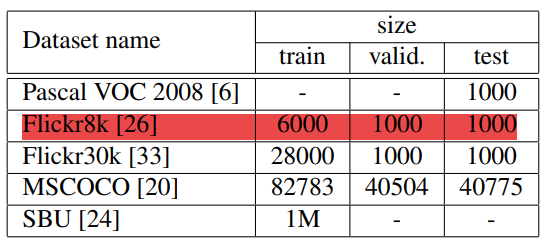



> As stated in the paper we split the 8000 samples from the Dataset to 6000 for training ,1000 for testing and 1000 for validation but as the data downloaded from kaggle is 8091 sample we decided to split like 5618 1124 1349 to ensure the same ratio as possible



# **3- Dataset**


---

we first tokenizing and padding sequences of text data using TensorFlow and Keras. we created a tokenizer object and fits it on the training data. The tokenizer object creates a word index, which maps words in the vocabulary to their numeric representation, and tokenizes the text data by turning each text into a sequence of integers, where each integer is the index of a token in the dictionary. The code then pads each vector to the max_length of the captions using the pad_sequences method. If a max_length value is not provided, `pad_sequences` calculates it automatically. The `train_cap_vector`, `val_cap_vector`, and `test_cap_vector` are created by padding each vector to the max_length of the captions. Finally, the code creates three tf.data.Dataset objects from the padded vectors. then loaded images from a given path, resizes them to a specified size, and converts them to float32 data type. The function uses three datasets, train_ds, val_ds, and test_ds, each containing a combination of image and caption data. The datasets are batched and prefetched using the AUTOTUNE and BATCH_SIZE parameters. The function uses the TensorFlow library functions, including tf.io.read_file, tf.image.decode_jpeg, tf.image.convert_image_dtype, tf.image.resize, and tf.data.Dataset. The code is part of a machine learning model that trains on image and caption data.


In [7]:
class Flickr8k(Dataset):
    def __init__(self,images_path,captions_file,transform = None,freq_threshold=4):
        self.images_path = images_path
        self.captions_file = captions_file
        self.dataframe = pd.read_csv(captions_file)
        self.transform = transform

        # Get img, caption columns
        self.imgs = self.dataframe["image"]
        self.captions = self.dataframe["caption"]

        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

        # Splitting it into train and test datasets
        self.train_imgs , self.test_imgs , self.train_captions , self.test_captions = train_test_split(self.imgs,self.captions,test_size=0.2,train_size=0.8,random_state=1,shuffle=True)

        self.train_imgs.reset_index(drop=True, inplace=True)
        self.train_captions.reset_index(drop=True, inplace=True)
        self.test_imgs.reset_index(drop=True, inplace=True)
        self.test_captions.reset_index(drop=True, inplace=True)

    def get_training_data(self):
        return self.train_imgs, self.train_captions

    def get_testing_data(self):
        return self.test_imgs, self.test_captions


In [8]:
class Flickr8k_Training(Dataset):
    def __init__(self, images_path , train_imgs, train_captions, vocab, transform=None):
        self.images_path = images_path
        self.transform = transform
        self.imgs = train_imgs
        self.captions = train_captions

        # Initialize vocabulary and build vocab
        self.vocab = vocab

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.images_path, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)


class Flickr8k_Testing(Dataset):
    def __init__(self, images_path, test_imgs, test_captions, vocab, transform=None):
        self.images_path = images_path
        self.transform = transform
        self.imgs = test_imgs
        self.captions = test_captions

        # Initialize vocabulary and build vocab
        self.vocab = vocab

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.images_path, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)

class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets

In [9]:
def get_loader(root_folder,
    annotation_file,
    transform,
    batch_size=32,
    num_workers=2,
    shuffle=True,
    pin_memory=True,
    ):
    dataset = Flickr8k(root_folder,annotation_file,transform)
    train_imgs , train_captions = dataset.get_training_data()
    test_imgs , test_captions = dataset.get_testing_data()

    train_dataset = Flickr8k_Training(root_folder,train_imgs,train_captions,dataset.vocab,transform)
    test_dataset = Flickr8k_Testing(root_folder,test_imgs,test_captions,dataset.vocab,transform)

    pad_idx_train = train_dataset.vocab.stoi["<PAD>"]
    pad_idx_test = test_dataset.vocab.stoi["<PAD>"]

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx_train),
    )

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx_test),
    )

    return train_loader, test_loader, train_dataset, test_dataset,test_imgs, test_captions

In [10]:
transform = transforms.Compose(
        [transforms.Resize((224, 224)), transforms.ToTensor(), ]
    )
train_loader, test_loader, train_dataset, test_dataset,test_imgs, test_captions= get_loader(
    "Images/", "captions.txt", transform=transform
)


# **4- Model**


---
The paper Explains that there is a recent work by `J. Mao, Explain images with multimodal recurrent neural networks.` uses a recurrent NN for the same
prediction task but there is some important differences:

*   They use a
more powerful RNN model, and provide the visual input to
the RNN model directly, which makes it possible for the
RNN to keep track of the objects that have been explained
by the text.



> Their approach, use two separate pathways (one for `images`, one for `text`) to define a joint
embedding, and, even though they can generate text, their
approach is highly tuned for ranking.

<br>


---
<br>

Given a powerful sequence model, it is possible to achieve
state-of-the-art results by directly maximizing the probability of the correct translation given an input sentence in
an “end-to-end” fashion – both for training and inference.
So that:


*   These models make use of a recurrent neural network which
encodes the variable length input into a fixed dimensional
vector, and uses this representation to “decode” it to the desired output sentence





> Thus, it is natural to use the same approach where, given an image (instead of an input sentence
in the source language), one applies the same principle of
“translating” it into its description.


---

<br>

The paper propose to directly maximize the probability of
the correct description given the image by using the following formulation:

<br>

$$ \theta^{*} = arg\max_{\theta} \sum_{(I , S)} log \, p(S | I ; \theta) $$

<br>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  $\theta$  is the Parameters of our model  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $I$  is the  Image      &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   $S$  is the  Sentence  

(S, I) is a training example pair, and we optimize the sum of the log probabilities over the whole training set using stochastic gradient descent

It is natural to model:  $$p(St|I, S0, . . . , St−1)$$ with a Recurrent Neural Network (RNN), where the variable number
of words we condition upon up to t − 1 is expressed by a
fixed length hidden state or memory ht. This memory is
updated after seeing a new input xt by using a non-linear
function f:

$$h𝚝+1 = f(ht, xt) $$

<br>

Two crucial design choices are to be made:
*     what is the exact form of `f` and
how are the images and words fed as inputs `xt`. For `f` we
use a Long-Short Term Memory (`LSTM`) net.
*   For the representation of images, we use a Convolutional
Neural Network (`CNN`).


---


TODO : ExPLAIN LSTm

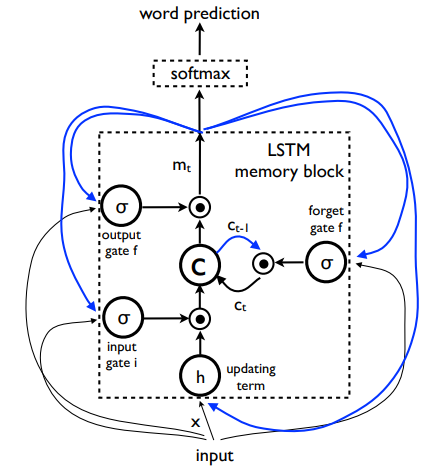

In [11]:
import torch
import torch.nn as nn
import torchvision.models as model

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN,self).__init__()

        # pretrained GoogLeNet model from PyTorch , aux_logits = False because we do not need to train
        # the whole model again and auxillary outputs is useful only while training.
        self.model = torch.hub.load('pytorch/vision:v0.9.0', 'googlenet', pretrained=True)

        # freezing all the layers of the GoogLeNet model
        for param in self.model.parameters():
            param.requires_grad = False

        # replacing the last layer of the model with a linear layer with output size as the embed_size
        self.model.fc = nn.Linear(self.model.fc.in_features,embed_size)

        # dropout layer
        self.dropout = nn.Dropout(p=0.5)

        # activation layer
        self.relu = nn.ReLU()

    def forward(self, images):
        # getting the latent representation of our image
        output = self.model(images)

        # applying relu activation and dropout layer
        return self.dropout(self.relu(output))

In [12]:
class DecoderLSTM(nn.Module):
    def __init__(self,embed_size,hidden_size,vocab_size,num_layers):
        super(DecoderLSTM,self).__init__()

        # defining our class properties
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers

        # LSTM Cell
        self.lstm = nn.LSTM(input_size=self.embed_size,hidden_size=self.hidden_size,num_layers=self.num_layers)

        # Output Layer
        self.linear = nn.Linear(in_features=self.hidden_size,out_features=self.vocab_size)

        # Embedding Layer
        self.embedding = nn.Embedding(num_embeddings=self.vocab_size,embedding_dim=self.embed_size)

        # Dropout Layer
        self.dropout = nn.Dropout(p = 0.5)

    def forward(self, features, captions):
        # Getting the word embeddings for the captions
        word_embeddings = self.dropout(self.embedding(captions))

        # our input vector will be the feature vector from the images + target captions during each time step
        # during training
        word_embeddings = torch.cat((features.unsqueeze(0), word_embeddings), dim = 0)

        # Getting the cell state and the hidden state from the LSTM
        hidden_state, cell_state = self.lstm(word_embeddings)

        # Applying the linear layer to get a probability distribution output
        return self.linear(hidden_state)


In [13]:
class ImageToCaption(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(ImageToCaption,self).__init__()

        # Initializing the Encoder CNN
        self.encoder = EncoderCNN(embed_size)

        # Initializing the Decoder LSTM
        self.decoder = DecoderLSTM(embed_size,hidden_size,vocab_size,num_layers)

    def forward(self,images,captions):
        # Getting the latent representation of the image from the encoder
        features = self.encoder(images)

        # Returning the captions from the decoder LSTM during training time.
        return self.decoder(features,captions)

    def generate_caption(self,image,vocabulary,max_length = 50):
        # Initializing an empty list
        generated_caption = []

        # Inference time so no grad is required
        with torch.no_grad():

            # Defining the initial Input and the cell state
            x = self.encoder(image).unsqueeze(0)
            state = None

            for _ in range(max_length):
                # finding the hidden and cell states
                hidden, state = self.decoder.lstm(x,state)

                # applying the linear layer on the hidden state to get the output distribution
                output = self.decoder.linear(hidden.squeeze(0))

                # find out the word with the highest probability
                predicted = output.argmax(1)

                # appending the index of the word in our generated_caption list
                generated_caption.append(predicted.item())

                # setting the input for the next iteration
                x = self.decoder.embedding(predicted).unsqueeze(0)

                # if our model predicts End of Sequence then we just stop
                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

        # we convert the indices to the words
        return [vocabulary.itos[idx] for idx in generated_caption]

# **5- Training**

---

LSTM model is trained to predict each
word of the sentence after it has seen the image as well
as all preceding words as defined by $$p(St|I, S0, . . . , St−1)$$
For this purpose, it is instructive to think of the LSTM in unrolled form – a copy of the LSTM memory is created for the image and each sentence word such that all LSTMs share the same `parameters`.
<br><br>
In the paper, the authors represent each word as a one-hot vector of dimension equal to the size of the dictionary. They use a special start word S0 and a special stop word SN to designate the start and end of the sentence. The LSTM signals that a complete sentence has been generated by emitting the stop word. Both the image and the words are mapped to the same space, the image by using a vision CNN, the words by using word embedding We.
 <br><br>
But there is another approach that using `SparseCategoricalCrossentropy`, because here it would be inefficient to use one-hot-encoders are the ground truth. We will also use mask to help mask the <pad> so that we do not let the sequence model learn to overfit on the same They use SparseCategoricalCrossentropy because it would be inefficient to use one-hot-encoders as the ground truth. The authors also note that feeding the image at each time step as an extra input yields inferior results, as the network can explicitly exploit noise in the image and overfit more easily

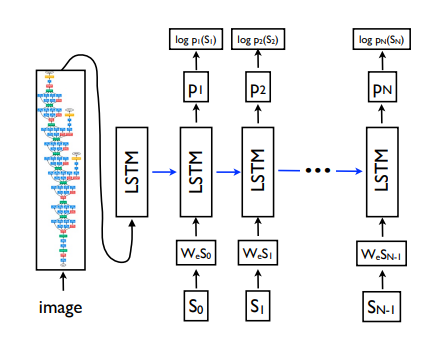


 <br>

---

 <br>

`CategoricalCrossentropy` expects the true labels to be provided in a one-hot representation, where each label is a vector of length equal to the number of classes, with a value of 1 for the true class and 0 for all other classes. This means that the output of the model is compared to a one-hot encoded vector representing the true label.

`SparseCategoricalCrossentropy`, on the other hand, expects the true labels to be provided as integers, where each integer represents the index of the true class. This means that the output of the model is compared to an integer representing the true label

the same loss

In [14]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter


def train():
    transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])

    train_loader, test_loader , train_dataset, test_dataset,_,_ = get_loader(root_folder="Images",annotation_file="captions.txt",transform=transform,num_workers=2,)

    save_train_dataloader(train_loader, filename="saved_train_dataloader.pt")
    save_test_dataloader(test_loader, filename="saved_test_dataloader.pt")
    save_train_dataset(train_dataset, filename="saved_train_dataset.pt")
    save_test_dataset(test_dataset, filename="saved_test_dataset.pt")

    torch.backends.cudnn.benchmark = True
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    load_model = False
    save_model = True
    train_CNN = False

    # Hyperparameters
    embed_size = 256
    hidden_size = 256
    vocab_size = len(train_dataset.vocab)
    num_layers = 1
    learning_rate = 3e-4
    num_epochs = 40


    # for tensorboard
    writer = SummaryWriter("runs/flickr")
    step = 0

    # initialize model, loss etc
    model = ImageToCaption(embed_size, hidden_size, vocab_size, num_layers).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.vocab.stoi["<PAD>"])
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    if load_model:
        step = load_checkpoint(torch.load("saved_checkpoint.pt"), model, optimizer)

    model.train()

    for epoch in range(num_epochs):
        if save_model:
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "step": step,
            }
            save_checkpoint(checkpoint)

        for idx, (imgs, captions) in tqdm(
                enumerate(train_loader), total=len(train_loader), leave=False
        ):
            imgs = imgs.to(device)
            captions = captions.to(device)

            outputs = model(imgs, captions[:-1])
            loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1))

            writer.add_scalar("Training loss", loss.item(), global_step=step)
            step += 1

            optimizer.zero_grad()
            loss.backward(loss)
            optimizer.step()


In [ ]:
train()

=> Saving Train Dataloader
=> Saving Test Dataloader
=> Saving Train Dataset
=> Saving Test Dataset


Downloading: "https://github.com/pytorch/vision/zipball/v0.9.0" to /root/.cache/torch/hub/v0.9.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 152MB/s]


=> Saving checkpoint


 18%|█▊        | 183/1012 [29:18<2:10:32,  9.45s/it]

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as model
from tqdm import tqdm
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image  # Load img


def print_caption(model, image ,device, dataset):
    transform = transforms.Compose(
        [
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
    model.eval()
    test_img = transform(Image.open(image).convert("RGB")).unsqueeze(0)
    #print(generate_caption(model, test_img.to(device), dataset.vocab))
    return generate_caption(model, test_img.to(device), dataset.vocab)


def generate_caption(model, image, vocabulary, max_length=50):
    model.eval()
    # Initializing an empty list
    generated_caption = []

    # Inference time so no grad is required
    with torch.no_grad():

        # Defining the initial Input and the cell state
        x = model.encoder(image).unsqueeze(0)
        state = None

        for _ in range(max_length):
            # finding the hidden and cell states
            hidden, state = model.decoder.lstm(x, state)

            # applying the linear layer on the hidden state to get the output distribution
            output = model.decoder.linear(hidden.squeeze(0))

            # find out the word with the highest probability
            predicted = output.argmax(1)

            # appending the index of the word in our generated_caption list
            generated_caption.append(predicted.cpu().detach().numpy().tolist())

            # setting the input for the next iteration
            x = model.decoder.embedding(predicted).unsqueeze(0)

            # if our model predicts End of Sequence then we just stop
            if vocabulary.itos[predicted.item()] == "<EOS>":
                break

    # return generated_caption
    # we convert the indices to the words
    caption = []
    for i in range(len(generated_caption)):
        idx = int(generated_caption[i][0])
        caption.append(vocabulary.itos[idx])
    return caption

In [ ]:
import IPython.display as display
from nltk.translate.bleu_score import sentence_bleu
train_dataloader = torch.load("saved_train_dataloader.pt")
test_dataloader = torch.load("saved_test_dataloader.pt")
train_dataset = torch.load("saved_train_dataset.pt")
test_dataset = torch.load("saved_test_dataset.pt")

# Hyper-Parameters
embed_size = 256
hidden_size = 256
vocab_size = len(train_dataset.vocab)
num_layers = 1
learning_rate = 3e-4
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

# initialize model, loss etc
model = ImageToCaption(embed_size, hidden_size, vocab_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=test_dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

step = load_checkpoint(torch.load("saved_checkpoint.pt"), model, optimizer)
sum_blue = 0
for idx in range(8091):
  reference = test_captions[idx].split()
  candidate = print_caption(model, "/content/Images/"+ test_imgs[idx],device, test_dataset)
  candidate = candidate[1:-1]
  bleu_score = sentence_bleu([reference], candidate)
  sum_blue += bleu_score
  # Load and convert the image to RGB
  image = Image.open("/content/Images/"+ test_imgs[idx]).convert("RGB")

  # Display the image
  display.display(image)

  # Print the caption below the image
  print()
  print("Ground truth: ")
  print(  reference)
  print("Generated: " )
  print( candidate)
  print("BLUE score: " )
  print( bleu_score)
  print()

print("Average BLUE score"+ sum_blue/8091.00)